In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from PIL import Image
from tqdm import tqdm
def im_with_bbox(img_rgb, bbox_height_start, bbox_height_end,
                     bbox_width_start, bbox_width_end, ax=None, color=(0, 255, 255)):
    img_bgr_uint8 = cv2.cvtColor(np.uint8(255*img_rgb), cv2.COLOR_RGB2BGR)
    cv2.rectangle(img_bgr_uint8, (bbox_width_start, bbox_height_start), (bbox_width_end-1, bbox_height_end-1),
                  color, thickness=2)
    img_rgb_uint8 = img_bgr_uint8[...,::-1]
    img_rgb_float = np.float32(img_rgb_uint8) / 255
    #plt.imshow(img_rgb_float)
    #plt.axis('off')
    if ax is not None:
        ax.imshow(img_rgb_float)
        ax.axis('off')
    plt.imshow(img_rgb_float)

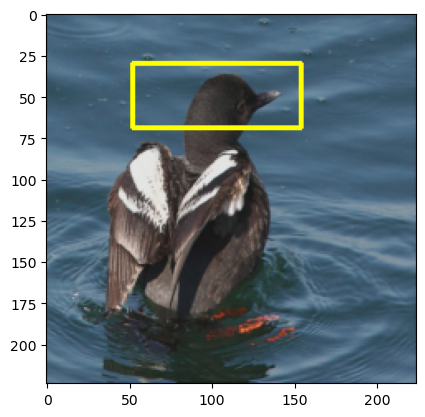

In [2]:
bbx = np.load("local_analysis/handful_of_images/058.Pigeon_Guillemot/Resnet34/002/15push0.7530.pth/most_activated_prototypes/top-1_activated_prototype_bbox.npy")
guillemot = plt.imread('local_analysis/handful_of_images/058.Pigeon_Guillemot/Resnet34/002/15push0.7530.pth/original_img.png')

im_with_bbox(img_rgb=guillemot,
            bbox_height_start=bbx[0],
            bbox_height_end=bbx[1],
            bbox_width_start=bbx[2],
            bbox_width_end=bbx[3], color=(0, 255, 255))

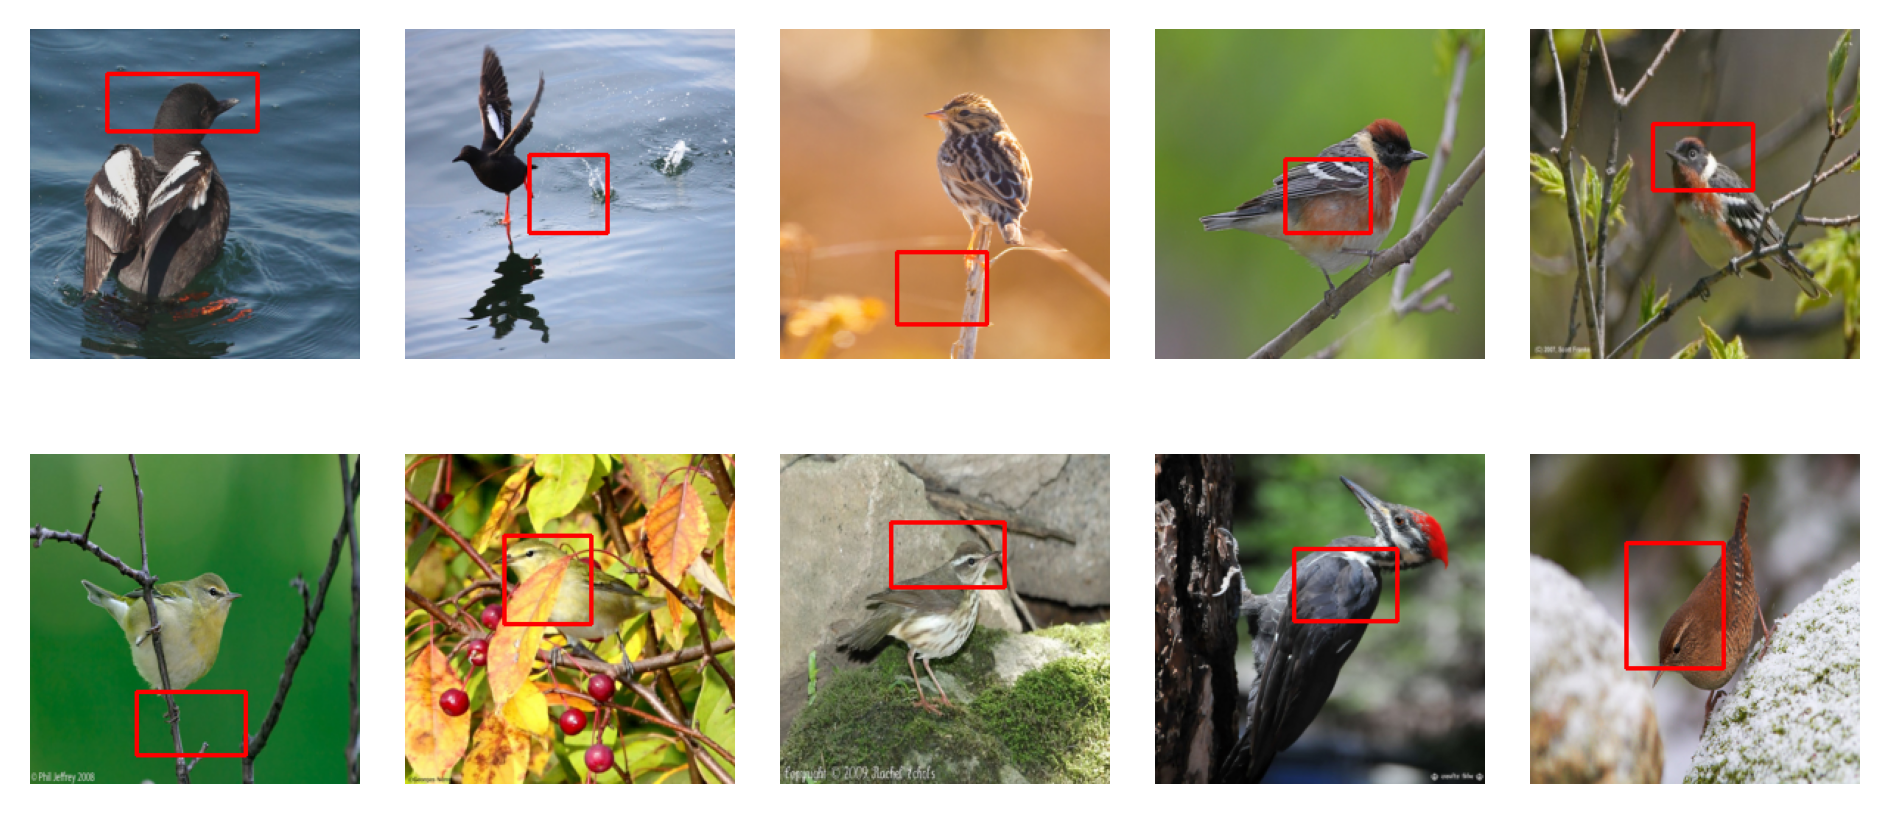

In [3]:
img_paths = glob.glob('local_analysis/handful_of_images/*/Resnet34/002/15push0.7530.pth/original_img.png')
bboxes = glob.glob("local_analysis/handful_of_images/*/Resnet34/002/15push0.7530.pth/most_activated_prototypes/top-1*.npy")
fig, ax = plt.subplots(2,5, dpi=300, tight_layout=True)
ax = ax.ravel()
for i, (img_path, bbx_path) in enumerate(zip(img_paths, bboxes)):
    img = plt.imread(img_path)
    bbx = np.load(bbx_path)
    im_with_bbox(img_rgb=img,
                 bbox_height_start=bbx[0],
                 bbox_height_end=bbx[1],
                 bbox_width_start=bbx[2],
                 bbox_width_end=bbx[3], ax=ax[i], color=(0, 0, 255))
plt.savefig('figures/ProtoP_bboxes.png', bbox_inches='tight')

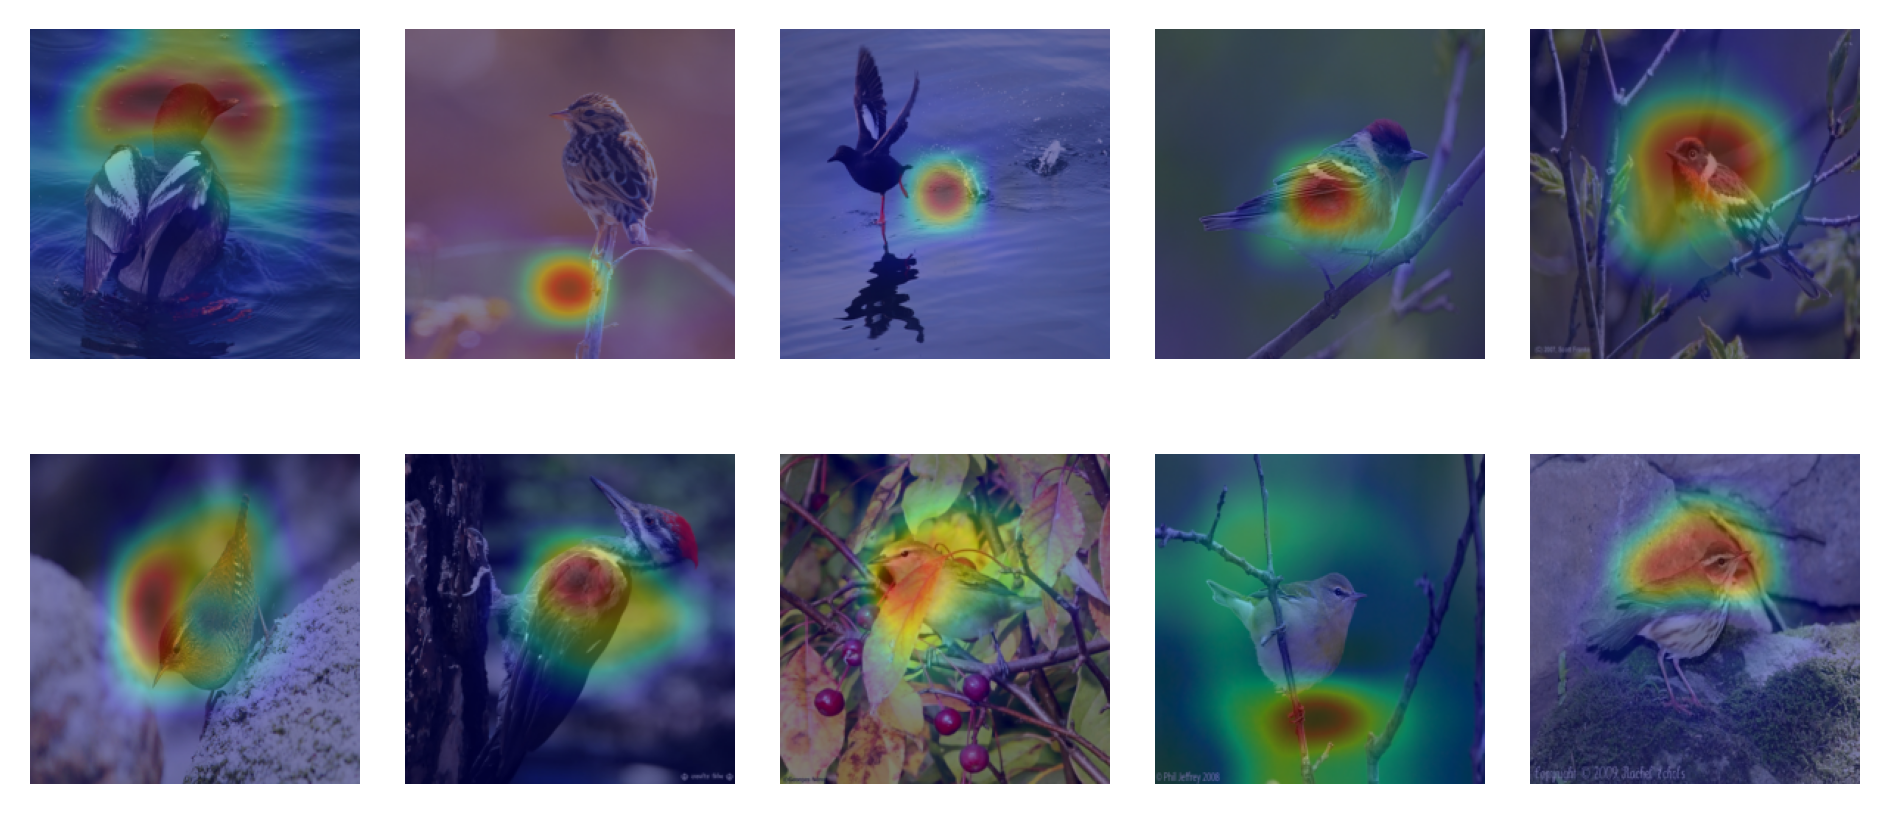

In [4]:
heatmaps = glob.glob('local_analysis/handful_of_images/*/Resnet34/002/15push0.7530.pth/most_activated_prototypes/prototype_activation_map_by_top-1_prototype.png')
fig, ax = plt.subplots(2,5, dpi=300, tight_layout=True)
ax = ax.ravel()

ax[0].imshow(plt.imread(heatmaps[0]))
ax[1].imshow(plt.imread(heatmaps[2]))
ax[2].imshow(plt.imread(heatmaps[1]))
ax[3].imshow(plt.imread(heatmaps[3]))
ax[4].imshow(plt.imread(heatmaps[4]))
ax[5].imshow(plt.imread(heatmaps[9]))
ax[6].imshow(plt.imread(heatmaps[8]))
ax[7].imshow(plt.imread(heatmaps[6]))
ax[8].imshow(plt.imread(heatmaps[5]))
ax[9].imshow(plt.imread(heatmaps[7]))

for i, heatmap in enumerate(heatmaps):
    ax[i].set_axis_off()
plt.savefig('figures/ProtoP_heatmaps.png', bbox_inches='tight')

In [3]:
# Using the bbox dataframe
# get the valid images
img_id_to_path = pd.read_csv('datasets/CUB_200_2011/images.txt', sep=' ', header=None, names=['img_id', 'path'])
img_id_to_path = dict(img_id_to_path.values)
img_id_to_bbx = pd.read_csv('datasets/CUB_200_2011/bounding_boxes.txt', sep=' ', header=None, names=['img_id', 'x', 'y', 'w', 'h'])
train_test_split = pd.read_csv('datasets/CUB_200_2011/train_test_split.txt', sep=' ', header=None, names=['img_id', 'is_train'])
train_test_split = dict(train_test_split.values)

img_id_to_path = {idx: path for idx, path in img_id_to_path.items() if train_test_split[idx] == 0}

bboxes = pd.read_csv('bboxes.csv', index_col=0)
bboxes

xmin  ymin  xmax  ymax
id                           
1        54   130   125   187
3       110    64   169   125
6         0     0   224    39
10       30    42   122   107
12       66    47   129    99
...     ...   ...   ...   ...
11780    57    33   139   122
11783   121    45   167   114
11785    72    59   135   120
11786    90    89   148   146
11788    75     0   159    98

[5794 rows x 4 columns]

(386, 500, 3)


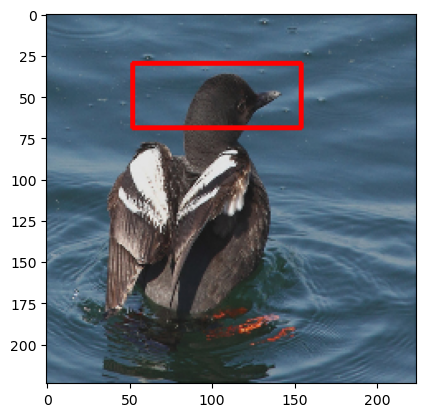

In [11]:
# sanity check that the bboxes are correct
path_to_id = {v: k for k, v in img_id_to_path.items()}
img_id = path_to_id['058.Pigeon_Guillemot/Pigeon_Guillemot_0043_39861.jpg']

xmin, ymin, xmax, ymax = bboxes[bboxes.index == img_id].values.flatten()

img = cv2.imread('datasets/CUB_200_2011/images/' + '058.Pigeon_Guillemot/Pigeon_Guillemot_0043_39861.jpg')[:,:,::-1]

# pretty sure that the images need to be resized to 224x224 for the bounding boxes to make sense
# but I am not sure. See line 109 of get_all_bboxes.py. there the activation pattern is resized to 224x224
img = np.array(cv2.resize(img, (224,224))).astype(float) / 255

im_with_bbox(img_rgb=img,
            bbox_height_start=ymin,
            bbox_height_end=ymax,
            bbox_width_start=xmin,
            bbox_width_end=xmax, color=(0, 0, 255))

# everything is good, it matches the above image in cell 2

In [23]:
bboxes_scaled = bboxes.copy()
for img_id, path in tqdm(img_id_to_path.items()):
    xmin, ymin, xmax, ymax = bboxes[bboxes.index == img_id].values.flatten()
    img = cv2.imread('datasets/CUB_200_2011/images/' + path)[:,:,::-1].astype(float) / 255
#     print(img.shape)
    # scale bounding boxes to image size
    xmin = int(xmin / 224 * img.shape[1])
    xmax = int(xmax / 224 * img.shape[1])
    ymin = int(ymin / 224 * img.shape[0])
    ymax = int(ymax / 224 * img.shape[0])
    bboxes_scaled.loc[img_id] = [xmin, ymin, xmax, ymax]
bboxes_scaled

xmin  ymin  xmax  ymax
id                           
1       120   194   279   279
3       245    99   377   193
6         0     0   500    81
10       33    39   136    99
12      123    58   241   123
...     ...   ...   ...   ...
11780   127    58   310   217
11783   270    66   372   169
11785   160    87   301   178
11786   200   150   330   247
11788   119     0   253   218

[5794 rows x 4 columns]

In [ ]:
bboxes_scaled.to_csv('bboxes_scaled.csv')

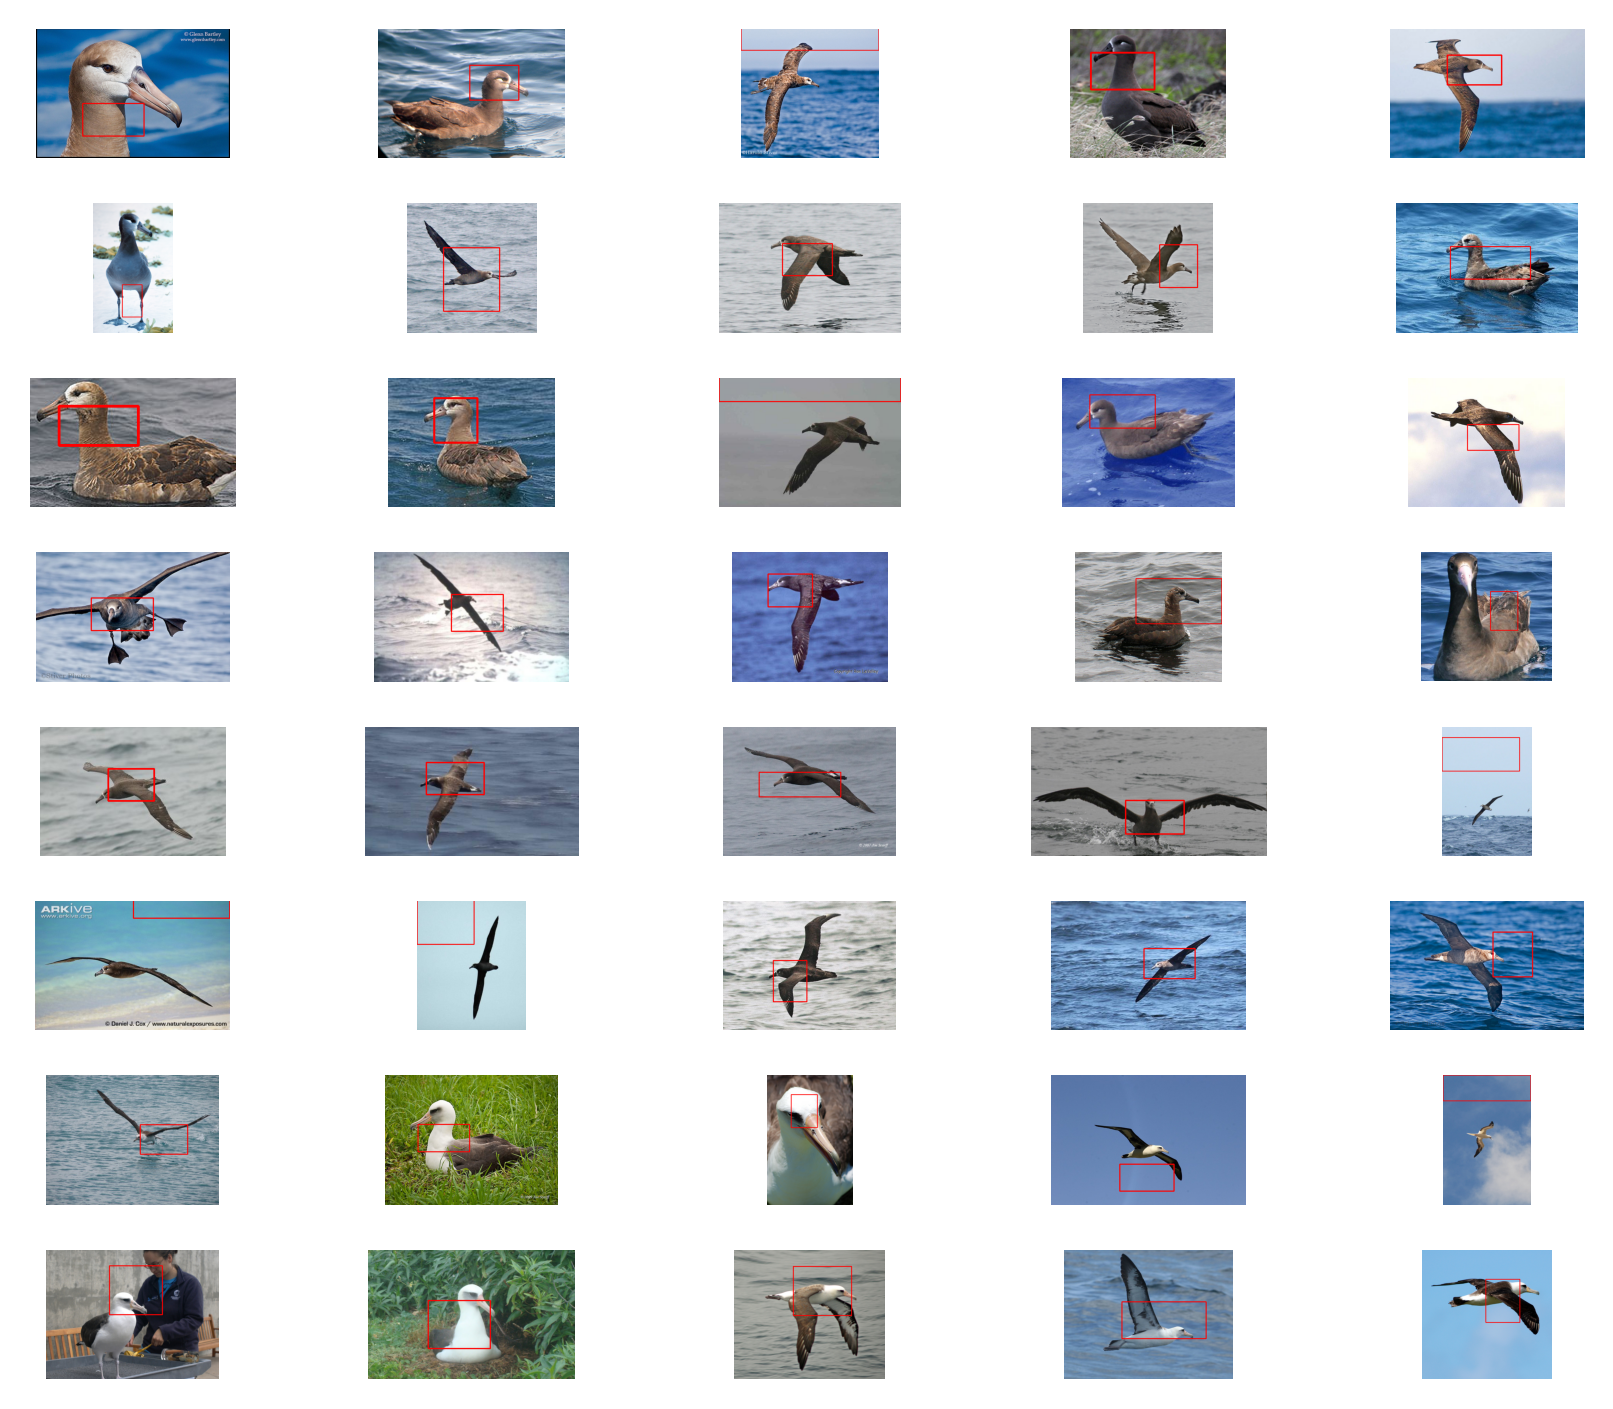

In [25]:
i = 0
fig, ax = plt.subplots(8,5, dpi=300, tight_layout=True)
ax = ax.ravel()
for img_id, path in img_id_to_path.items():
    xmin, ymin, xmax, ymax = bboxes_scaled[bboxes.index == img_id].values.flatten()

    img = cv2.imread('datasets/CUB_200_2011/images/' + path)[:,:,::-1].astype(float) / 255
    # pretty sure that the images need to be resized to 224x224 for the bounding boxes to make sense
    # but I am not sure. See line 109 of get_all_bboxes.py. there the activation pattern is resized to 224x224
    # img = np.array(cv2.resize(img, (224,224)))


    im_with_bbox(img_rgb=img,
                bbox_height_start=ymin,
                bbox_height_end=ymax,
                bbox_width_start=xmin,
                bbox_width_end=xmax,ax=ax[i], color=(0, 0, 255))
    i += 1
    if i == 8*5:
        break
